# Application de la segmentation


## Qu'est-ce que la segmentation ?


Dans les notebooks précédents, nous avons traité uniquement des problèmes de classification, c'est-à-dire prédire une classe à partir d'une image (par exemple, "c'est une image de 5" ou "c'est une image de chat").
Cependant, il existe deux autres catégories d'analyse d'images : la détection et la segmentation.


### Détection d'objets dans une image


La détection d'objets dans une image consiste à encadrer un objet dans l'image. Par exemple, si l'on cherche à détecter les chats et qu'une image contient un chien et un chat, on entraîne un modèle pour dessiner une boîte autour du chat.

Voici une image pour visualiser l'idée de la détection d'objets :

![Détection](./images/detection.png)

Image provenant du [blogpost](https://machinethink.net/blog/object-detection-with-yolo/).


Comme vous pouvez l'imaginer, c'est une tâche très intéressante pour le domaine du traitement d'images, mais ce n'est pas ce que nous allons aborder dans ce notebook.


### Segmentation d'objets dans une image


La segmentation vise à déterminer la classe d'appartenance de chaque pixel de l'image (par exemple, le pixel en position (120, 300) appartient à un chien). L'objectif est d'obtenir des informations très précises sur le contenu de l'image au niveau du pixel.

![Segmentation](./images/Segmentation.png)

Image provenant du [blogpost](https://towardsai.net/p/l/machine-learning-7).


Il existe plusieurs types de segmentation :
- **La segmentation sémantique** : Elle consiste à classer chaque pixel de l'image indépendamment de l'instance (par exemple, toutes les voitures seront colorées en rouge). C'est le type de segmentation que vous voyez sur l'image ci-dessus.
- **La segmentation d'instance** : Ici, chaque instance d'une même classe est segmentée avec une couleur différente (par exemple, la première voiture en rouge, la seconde en orange, etc.).
- Il existe également d'autres types de segmentation. Pour plus d'informations, vous pouvez consulter le [blogpost](https://medium.com/@arulkumarark1924/image-segmentation-techniques-for-computer-vision-bc5a68a4aa10).


Dans ce notebook, nous allons faire un exemple de segmentation sémantique.


## Dataset utilisé


Nous utilisons le dataset [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), qui contient un total de 7349 images, dont 4978 images de chiens et 2371 images de chats. Pour chaque image, il y a les annotations de segmentation ainsi que la boîte entourant la tête de l'animal.

![Oxford Pet](./images/oxford_pet.jpg)


Nous utiliserons uniquement l'annotation correspondant à la segmentation de l'animal.


Pour récupérer et utiliser le dataset, il faut le télécharger directement sur le site, car la version proposée par torchvision n'inclut pas les masques de segmentation.


Lorsque le dataset que vous souhaitez utiliser n'est pas directement disponible sur torchvision, il est nécessaire de créer une classe héritant de la classe Dataset pour spécifier la gestion des données de ce dataset.


In [7]:
# Import nécessaire pour le projet
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import numpy as np

In [ ]:
class datasetSeg(Dataset):
  def __init__(self, path):
    self.path = path
    self.imagesPath,self.masksPath=self.loadDataset()
    
    self.resize=T.Resize((100, 100)) # Valeur de resize pour les images
    self.toTensor=T.ToTensor()
  
  def __len__(self):
    return len(self.imagesPath)
  
  def loadDataset(self): # Récuperation des liens vers les images et les annotations
    images=os.listdir(self.path+"images/")
    images=sorted(images)
    masks=os.listdir(self.path+"annotations/trimaps/")
    masks=sorted(masks)
    masks=[ mask for mask in masks if "._" not in mask ]
    images=[image for image in images if ".mat" not in image]
    return images, masks
  
  def __getitem__(self, index):
    image=Image.open(self.path+"images/"+self.imagesPath[index]).convert('RGB')
    # Resize des images et récuperation du masque de segmentation
    trimap=self.resize(Image.open(self.path+"annotations/trimaps/"+self.masksPath[index]).convert('L'))
    trimap=np.array(trimap)
    # Création des masques pour les classes
    class1 = (trimap == 1).astype(np.uint8)  
    class2 = (trimap == 2).astype(np.uint8)  
    class3 = (trimap == 3).astype(np.uint8)
    mask = np.stack([class1, class2, class3], axis=0)
    return self.toTensor(self.resize(image)), torch.tensor(mask)
        

Maintenant que nous avons créé notre classe dataset, nous pouvons charger notre dataset et examiner son contenu.


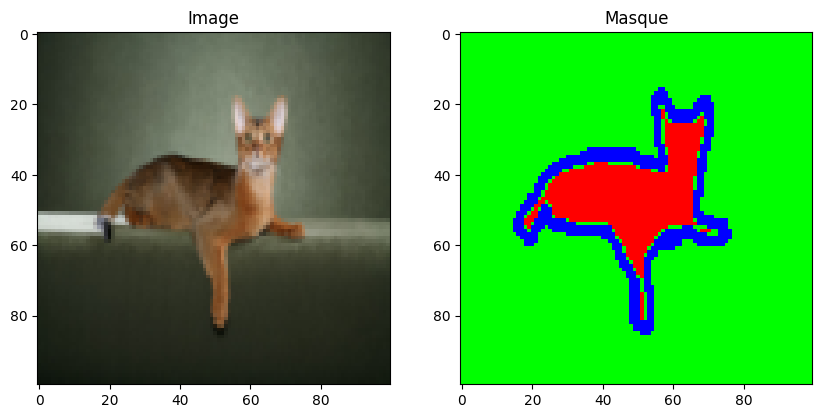

In [9]:
dataset=datasetSeg(path="./../data/OxfordPets/")
img=dataset[0][0].permute(1,2,0).numpy()
msk = dataset[0][1].permute(1, 2, 0).numpy() * 1.0

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img)
axs[0].set_title('Image')
axs[1].imshow(msk)
axs[1].set_title('Masque')
plt.show()

Nous avons bien l'image et sa segmentation. Maintenant, il est temps de diviser notre dataset et de définir nos dataloaders :


In [10]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset,[0.7, 0.2, 0.1])
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

## Architecture du modèle : U-Net


Contrairement à un problème de classification d'images, la sortie de notre réseau de neurones doit avoir la même dimension que l'entrée en résolution et un canal par classe que l'on souhaite segmenter (par exemple, si l'on veut segmenter dix classes sur des images d'entrée de taille $224 \times 224 \times 3$, on aura une sortie de taille $224 \times 224 \times 10$).
Une architecture classique de réseau convolutif, où la résolution diminue progressivement jusqu'à une couche fully connected de classification, n'est donc pas adaptée.
À la place, on peut utiliser l'architecture U-Net.


Voici à quoi ressemble l'architecture U-Net :

![U-Net](./images/unet.png)

Figure extraite de ce [blogpost](https://datasciencetoday.net/index.php/en-us/deep-learning/228-unet)


Comme vous pouvez le constater, l'architecture est plutôt atypique. Elle consiste en un chemin de contraction (appelé encodeur) qui réduit la taille de l'image comme un CNN classique, et un chemin d'expansion (appelé décodeur) qui augmente la taille de l'image jusqu'à une résolution identique à l'entrée. Les connexions indiquées par les flèches noires permettent de conserver une information locale précise, tandis que la partie encodeur/décodeur permet de détecter des relations plus abstraites entre différents pixels.
Cette architecture a été introduite pour la première fois pour la segmentation d'images médicales dans cet [article](https://arxiv.org/abs/1505.04597). Elle est maintenant utilisée dans de nombreux domaines (segmentation, dénoising, diffusion, etc.).


### Point sur la convolution transposée


Nous avons vu en détail les couches de convolutions, qui permettent d'effectuer des opérations sur les images avec des paramètres entraînables. On a vu que, grâce au paramètre stride, les couches de convolution permettent de conserver la résolution initiale ou de la diminuer.
Cependant, on a parfois besoin d'augmenter la résolution de l'image (par exemple, pour la partie décodeur du U-Net décrit ci-dessus).


Pour cela, on peut envisager plusieurs options :
- **Interpolation suivie d'une convolution** : À l'image du pooling mais dans l'autre sens, cette idée consiste à utiliser une fonction d'interpolation non entraînable pour agrandir artificiellement l'image.
- **Convolution transposée** : Cette opération joue le rôle de l'inverse d'une convolution et permet d'agrandir la taille de l'image. Voici un exemple de convolution transposée avec un kernel de taille $2 \times 2$. C'est une opération qui contient des paramètres entraînables.

![ConvT](./images/convT.png)

Figure extraite de [blogpost](https://d2l.ai/chapter_computer-vision/transposed-conv.html).


Pour ceux qui veulent entrer dans le détail et connaître les différences principales entre les deux techniques, je vous conseille la lecture de cet [article](https://distill.pub/2016/deconv-checkerboard/).

Dans notre implémentation, nous allons utiliser la convolution transposée.


### Implémentation PyTorch


Il est temps d'implémenter l'architecture U-Net en PyTorch :


In [11]:
# Fonction pour combiner couche de convolution, activation ReLU et BatchNorm pour éviter les copier coller 
def conv_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )
    
# Idem mais avec la convolution transposée
def convT_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )

class UNet(nn.Module):
  def __init__(self, num_classes=3):
    super().__init__()
    # encoder
    self.conv1=conv_relu_bn(3, 64, 3, 1, 1)
    self.conv2=conv_relu_bn(64, 64, 3, 1, 1)
    self.maxPool1=nn.MaxPool2d(2, 2)
    
    self.conv3=conv_relu_bn(64, 128, 3, 1, 1)
    self.conv4=conv_relu_bn(128, 128, 3, 1, 1)
    self.maxPool2=nn.MaxPool2d(2, 2)
    
    #Module central
    self.conv5=conv_relu_bn(128, 256, 3, 1, 1)
    self.conv6=conv_relu_bn(256, 256, 3, 1, 1)
    
    # Décodeur
    self.convT1=convT_relu_bn(256, 128, 4, 2, 1)
    self.conv7=conv_relu_bn(256, 128, 3, 1, 1)
    
    self.convT2=convT_relu_bn(128, 64, 4, 2, 1)
    self.conv8=conv_relu_bn(128, 64, 3, 1, 1)
    
    # On va prédire un channel par classe
    self.conv9=conv_relu_bn(64, num_classes, 3, 1, 1)     
    self.sigmoid=nn.Sigmoid()
  
  def forward(self,x):
    # Encodeur
    x=self.conv1(x)
    x1=self.conv2(x)
    
    x=self.maxPool1(x1)
    
    x=self.conv3(x)
    x2=self.conv4(x)
    x=self.maxPool2(x2)
    
    # Module central
    x=self.conv5(x)
    x=self.conv6(x)

    #Décodeur
    x=self.convT1(x)
    x=torch.cat((x,x2),dim=1)
    x=self.conv7(x)
    
    x=self.convT2(x)
    x=torch.cat((x,x1),dim=1)
    x=self.conv8(x)
    
    x=self.conv9(x)
    x=self.sigmoid(x)
    return x

## Entraînement du modèle


Pour entraîner le modèle, nous ne distinguerons pas entre les chiens et les chats, mais nous chercherons simplement à identifier les pixels appartenant à l'animal, les pixels de bordure et les pixels du fond.


In [12]:
# Nous défissons
model=UNet(num_classes=3).to('cuda')
criterion=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
epochs=5

La base de données est assez conséquente et le modèle est assez profond. Il est possible que l'entraînement dure plusieurs dizaines de minutes si votre GPU n'est pas très puissant. (Si vous n'avez pas de GPU, je ne vous conseille pas d'essayer d'entraîner le modèle).


In [13]:
for epoch in range(epochs):
  train_loss=0
  for images,masks in train_dataloader:
    images=images.to('cuda')
    masks=masks.to('cuda').float()
    optimizer.zero_grad()
    seg=model(images)
    loss=criterion(seg,masks)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  print(f"step {epoch} train loss {train_loss/len(train_dataloader)}")  
  val_loss=0
  for images,masks in val_dataloader:
    images=images.to('cuda')
    masks=masks.to('cuda').float()
    with torch.no_grad():
      seg=model(images)
      loss=criterion(seg,masks)
    val_loss += loss.item() 
  print(f"step {epoch} train loss {val_loss/len(val_dataloader)}")  

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


step 0 train loss 0.9442852522120063
step 0 train loss 0.9016501573806114
step 1 train loss 0.8738441905121744
step 1 train loss 0.8578698165873264
step 2 train loss 0.8354099944785789
step 2 train loss 0.8258832287281117
step 3 train loss 0.8052123431806211
step 3 train loss 0.7977393028583932
step 4 train loss 0.7819347337440208
step 4 train loss 0.7781971261856404


On peut maintenant calculer la précision sur nos données de test.


In [14]:
def calculate_class_accuracy(preds, masks, class_idx):
  #On convertit les prédictions en valeur entre 0 et 1 pour chaque classe
  preds = torch.argmax(preds, dim=1)
  
  # On ne récupère que les pixels de la classe d'intêret
  preds_class = (preds == class_idx).float()
  masks_class = (masks == class_idx).float()
  
  # Calculer la précision pour la classe choisie
  correct = (preds_class == masks_class).float()
  accuracy = correct.sum() / correct.numel()
  return accuracy

model.eval()
test_accuracy = 0.0
num_batches = 0


with torch.no_grad(): # Désactivation du calcul du gradient
  for images, masks in test_dataloader:
    images = images.to('cuda')
    masks = masks.to('cuda').long()
    
    seg = model(images)
    
    # On calcule la précision pour la classe d'intêret (0 correspond à la segmentation de l'animal)
    class_idx = 0
    batch_accuracy = calculate_class_accuracy(seg, masks, class_idx)
    
    test_accuracy += batch_accuracy.item()
    num_batches += 1

# On calcule la précision moyenne sur l'ensemble du dataset de test
test_accuracy /= num_batches
print(f'Précision pour la segmentation de l animal : {test_accuracy*100:.1f}%')

Précision pour la segmentation de l animal : 43.4%


### Visualisation


Nous pouvons visualiser les résultats de notre entraînement sur une image tirée du dataset de test. Pour une tâche de segmentation, c'est intéressant de regarder ce que le résultat donne sur un ou plusieurs exemples. Si vous lancez plusieurs fois le bloc de code suivant, vous pourrez voir la génération sur des images différentes.


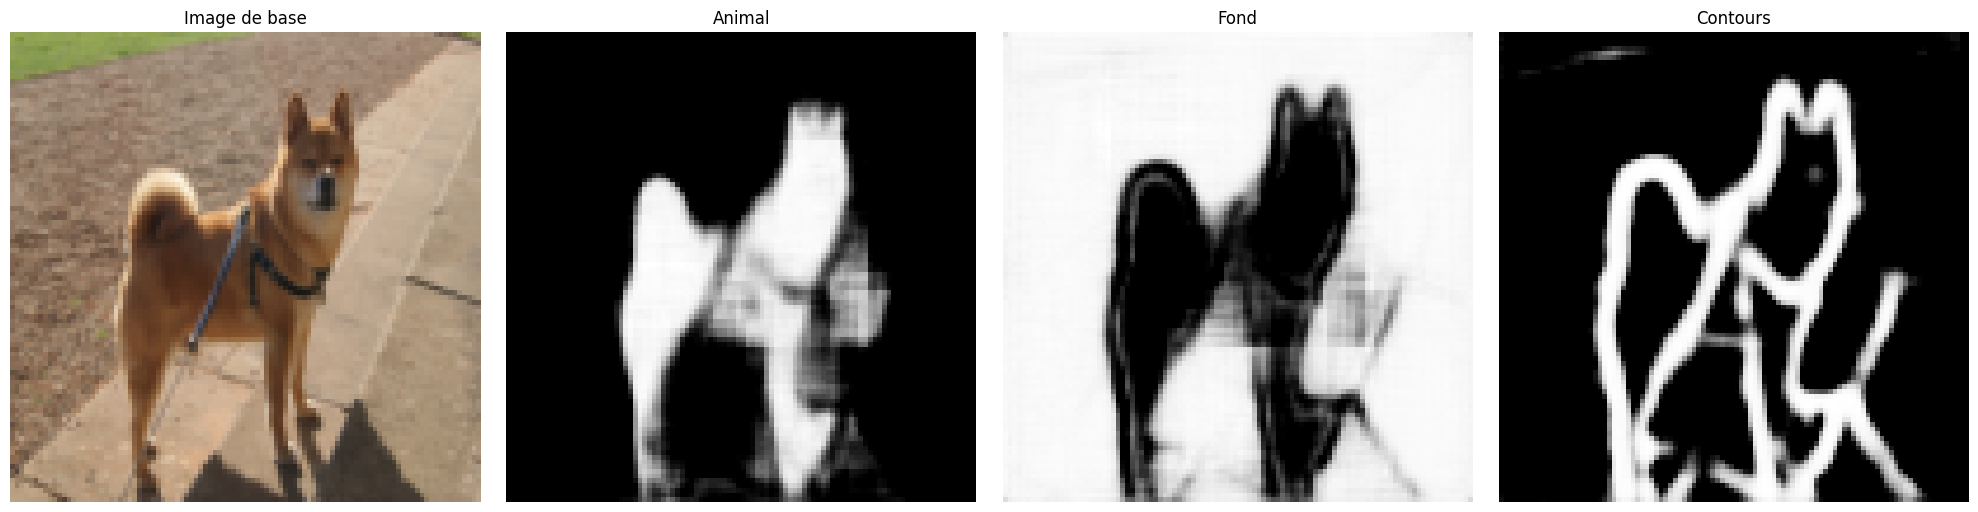

In [32]:
images,labels=next(iter(test_dataloader))

#Isolons un élément 
image=images[0].unsqueeze(0).to('cuda') # Le unsqueeze permet de garder la dimension batch
with torch.no_grad():
  seg=model(image)
    
# Affichons la segmentation prédite par le modèle pour cet élément
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Image de base')
axs[0].axis('off')

axs[1].imshow(seg[0][0].cpu().numpy(), cmap='gray')
axs[1].set_title('Animal')
axs[1].axis('off')

axs[2].imshow(seg[0][1].cpu().numpy(), cmap='gray')
axs[2].set_title('Fond')
axs[2].axis('off')

axs[3].imshow(seg[0][2].cpu().numpy(), cmap='gray')
axs[3].set_title('Contours')
axs[3].axis('off')

plt.tight_layout()
plt.show()

Malgré le score assez faible de 43% de précision, on remarque que la segmentation est correcte sur la majorité des images.


### Exercice à faire


Pour vous exercer, vous pouvez essayer d'améliorer les performances du modèle. Vous pouvez augmenter le nombre de couches, changer le nombre de filtres des couches, ajouter du *dropout*, utiliser la *batchnorm*, augmenter le nombre d'*epochs* d'entraînement, changer le *learning rate*, etc.
Essayez de maximiser les performances de votre modèle de segmentation !
